# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Summary
This notebook helps look at the measurements taken during the study period for the various sensors on the beacons.

In [10]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [1]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# Data Import

In [2]:
beacon_data = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0,parse_dates=True)
# show it off:
beacon_data.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4


# Base Visualization
Here we look at the raw, unaltered data in order to ascertain:
- what data are available? (see 4.1.1 notebook to see when participants actually measured data)
- what are typical measurements and what does this say?
- are there any misbehaving sensors?

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import LogNorm

## Heatmap
These heatmaps show the values, but are more useful for determining when data are available.

Working for PM_C_2p5
	Data collected
	Plotting


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


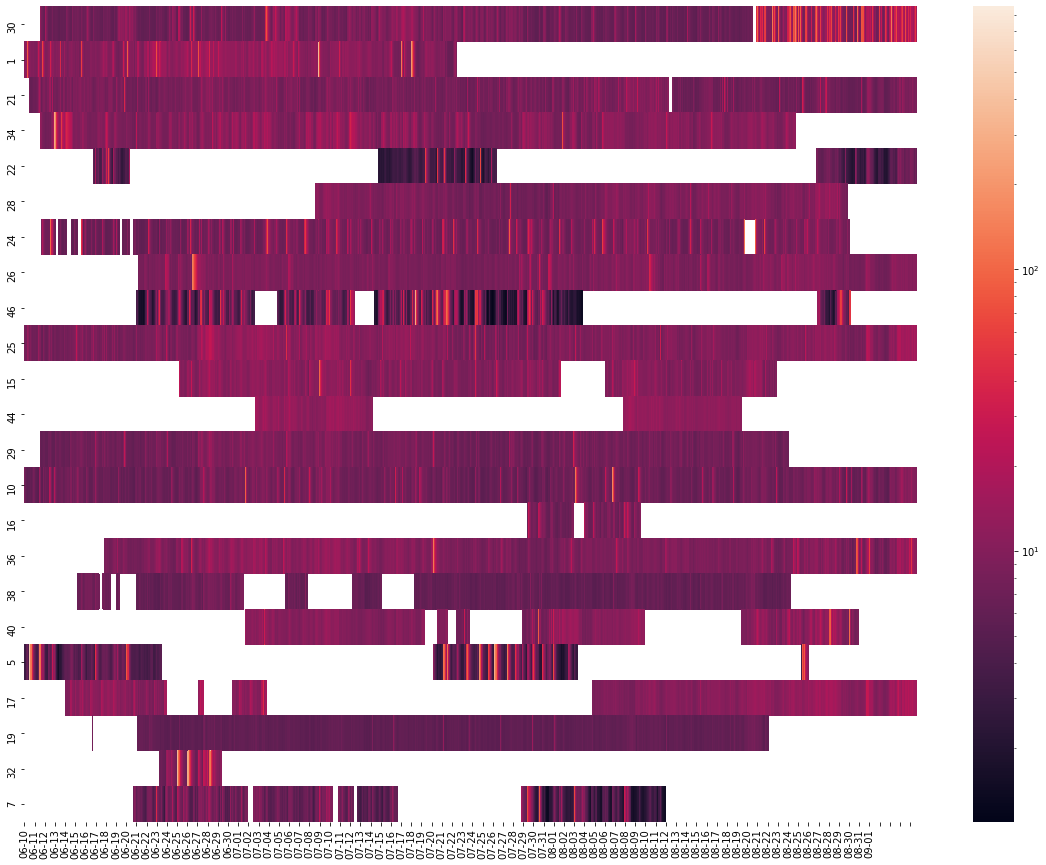

Working for CO2
	Data collected
	Plotting


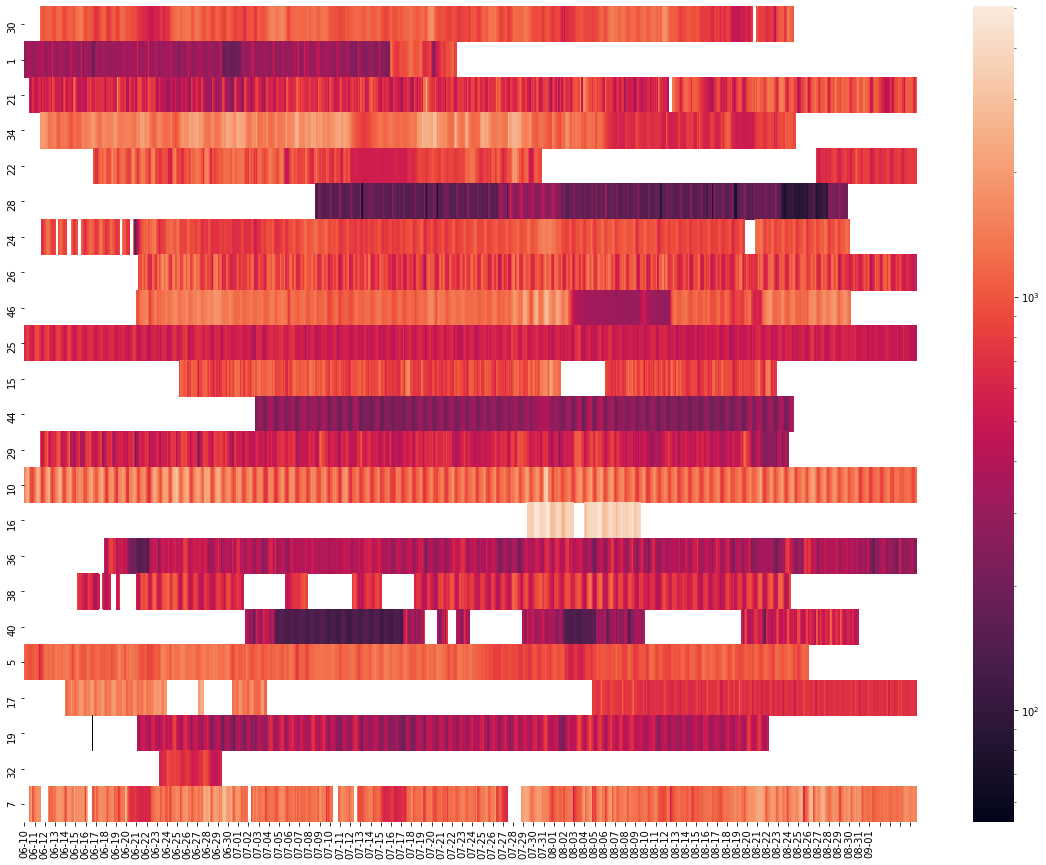

Working for CO
	Data collected
	Plotting


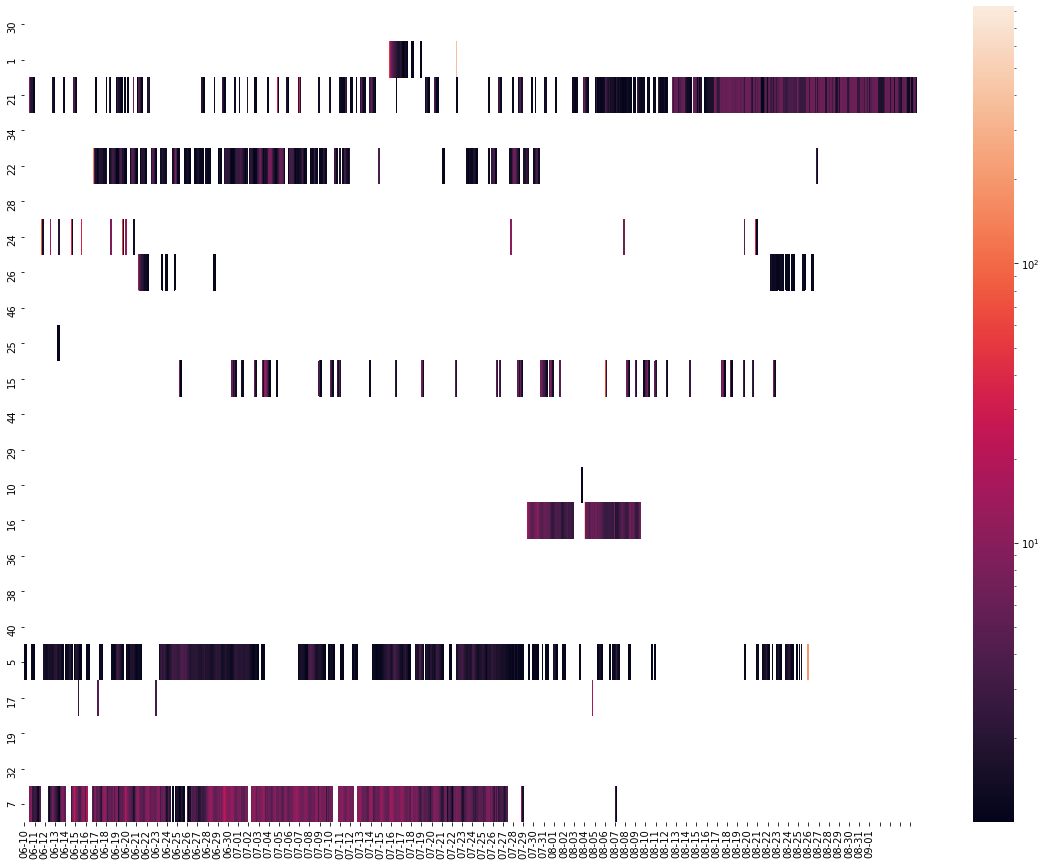

Working for NO2
	Data collected
	Plotting


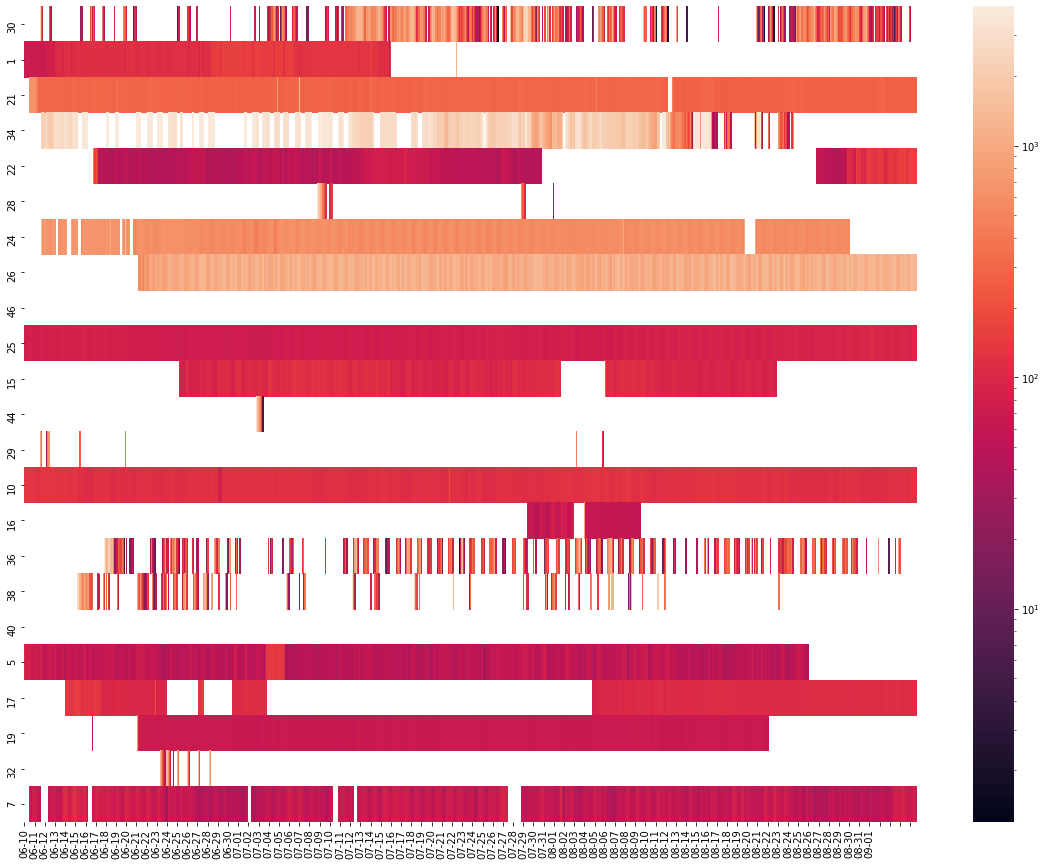

Working for T_NO2
	Data collected
	Plotting


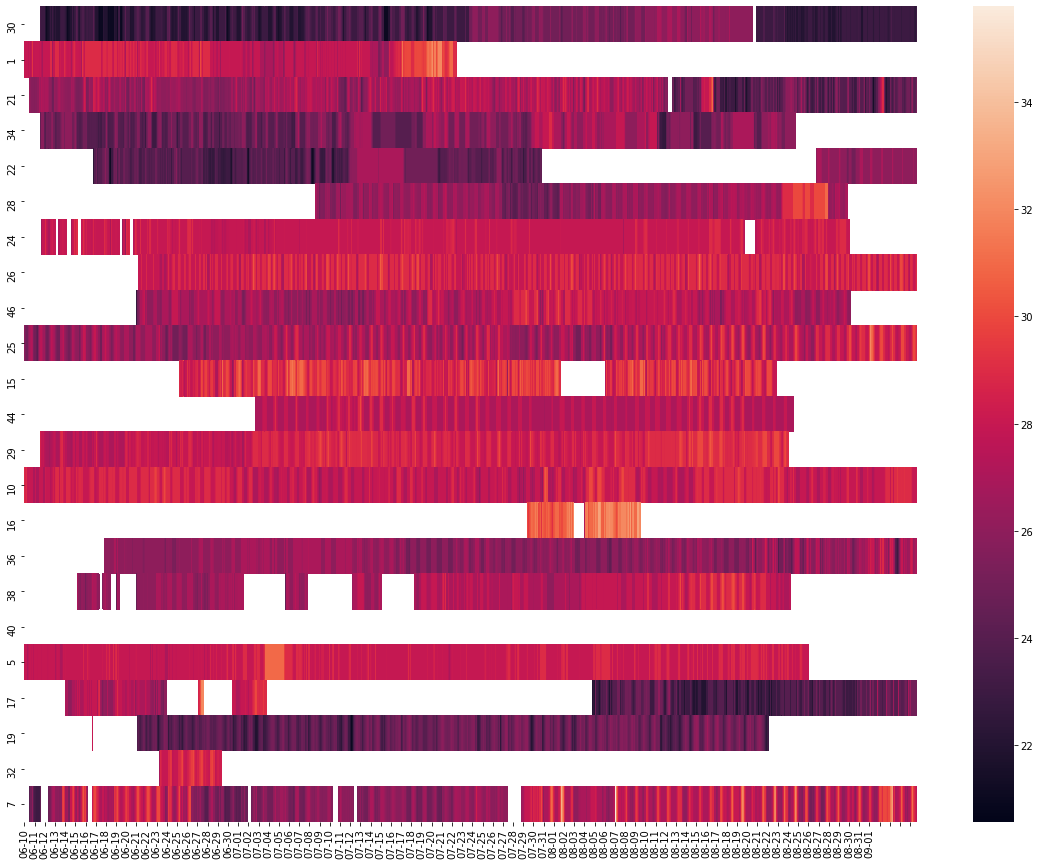

Working for Lux
	Data collected
	Plotting


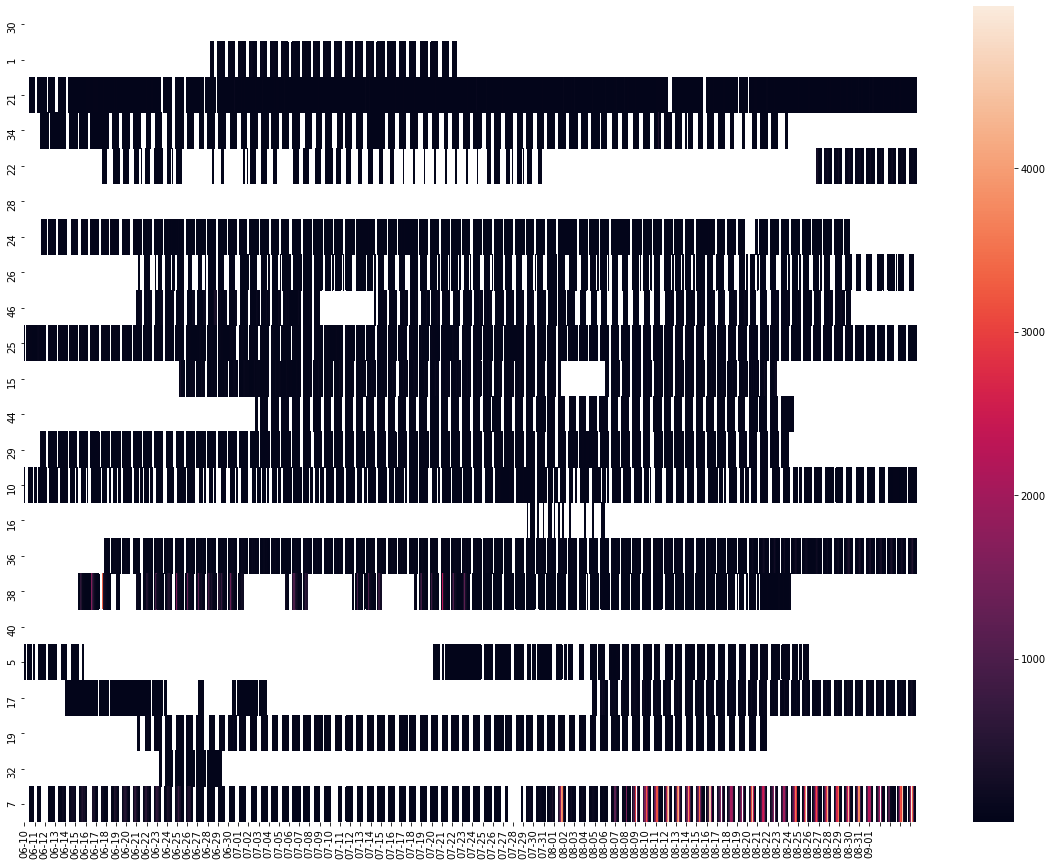

In [4]:
var_list = ['PM_C_2p5','CO2','CO','NO2','T_NO2','Lux']
limit_list = [[1,75],[1,2000],[1,20],[1,100],[1,50],[0,600000]]
for variable, limits in zip(var_list, limit_list):
    print(f'Working for {variable}')
    heatmap_df = pd.DataFrame()
    for beacon in beacon_data['Beacon'].unique():
        data_by_beacon = beacon_data[beacon_data['Beacon'] == beacon]
        data_by_beacon = data_by_beacon[data_by_beacon[variable] > 1]
        if variable == 'NO2':
            data_by_beacon = data_by_beacon[data_by_beacon[variable] < 5000]
        data_by_beacon = data_by_beacon.resample('1h').mean()
        sdate = datetime(2020,6,1)
        edate = datetime(2020,9,1)
        data_by_beacon = data_by_beacon[sdate:edate]
        heatmap_df = pd.concat([heatmap_df,data_by_beacon[variable]],axis=1)
        heatmap_df.rename(columns={variable:beacon}, inplace=True)

    print(f'\tData collected')
    fig, ax = plt.subplots(figsize=(20,15))
    df_to_plot = heatmap_df.T
    print(f'\tPlotting')
    if variable[0] in ['T','L']:
        sns.heatmap(df_to_plot,vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot))
    else:
        sns.heatmap(df_to_plot,norm=LogNorm(vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot)))
        
    x_labels = []
    for d in pd.date_range(sdate,edate-timedelta(days=1),freq='d'):
        x_labels.append(d.strftime('%m-%d'))
        
    ax.set_xticklabels(x_labels)
    
    plt.show()
    plt.close()

## Time Series Sensor Operation
Now we show individual beacons as a simplified time series to see that the sensors were operating.

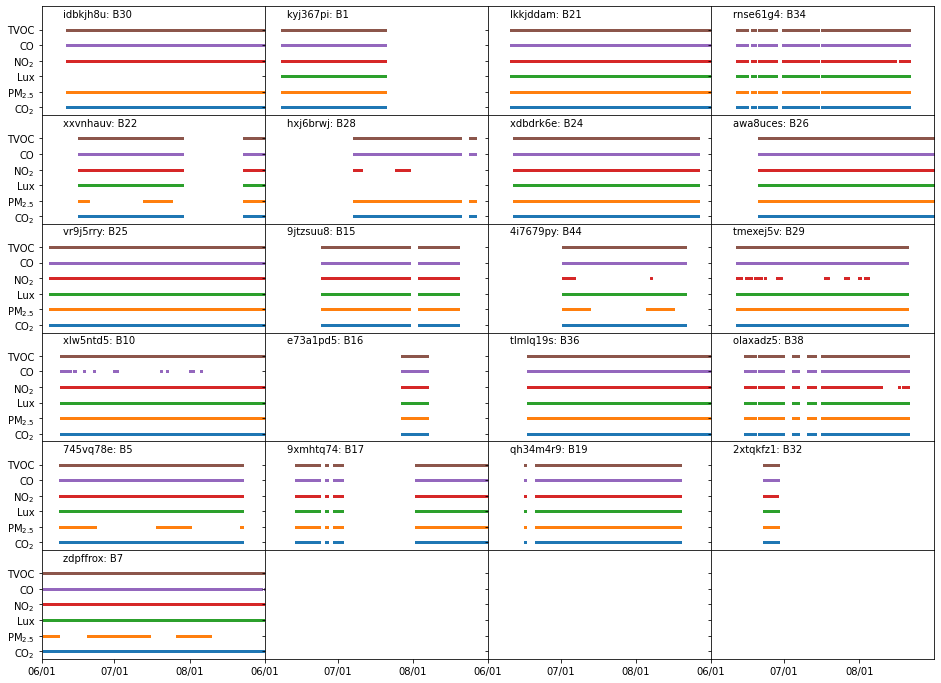

In [43]:
fig, axes = plt.subplots(6,4,figsize=(16,12),sharex=True,sharey='row')
rows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5]
cols = [0,1,2,3]*6
for beiwe, r, c in zip(beacon_data['Beiwe'].unique(),rows,cols):
    
    beacon_by_beiwe = beacon_data[beacon_data['Beiwe'] == beiwe]
    beacon = beacon_by_beiwe['Beacon'][0]
    sensors = ['CO2','PM_C_2p5','Lux','NO2','CO','TVOC']
    limits = [-50,0,-10,-1000,-1000,-50]
    i = 1
    ax = axes[r,c]
    for sensor, limit in zip(sensors,limits):
        beacon_by_beiwe[f'{sensor}_op'] = np.select([pd.to_numeric(beacon_by_beiwe[sensor],errors='coerce') > limit],[i])
        ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe[f'{sensor}_op'],s=5,marker='s')
        i += 1
    
    ax.text(datetime(2020,6,10),7,f'{beiwe}: B{beacon}',va='center',ha='left')
    ax.set_ylim([0.5,7.5])
    ax.set_xlim([datetime(2020,6,1),datetime(2020,9,1)])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[6,7,8]))
    ax.set_yticks(np.arange(1,7,1))
    ax.set_yticklabels(['CO$_2$','PM$_{2.5}$','Lux','NO$_2$','CO','TVOC'])
    
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()
plt.close()

## Density Plots
These plots help show typical measurements by the sensors

Working for PM_C_2p5
	Plotting


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


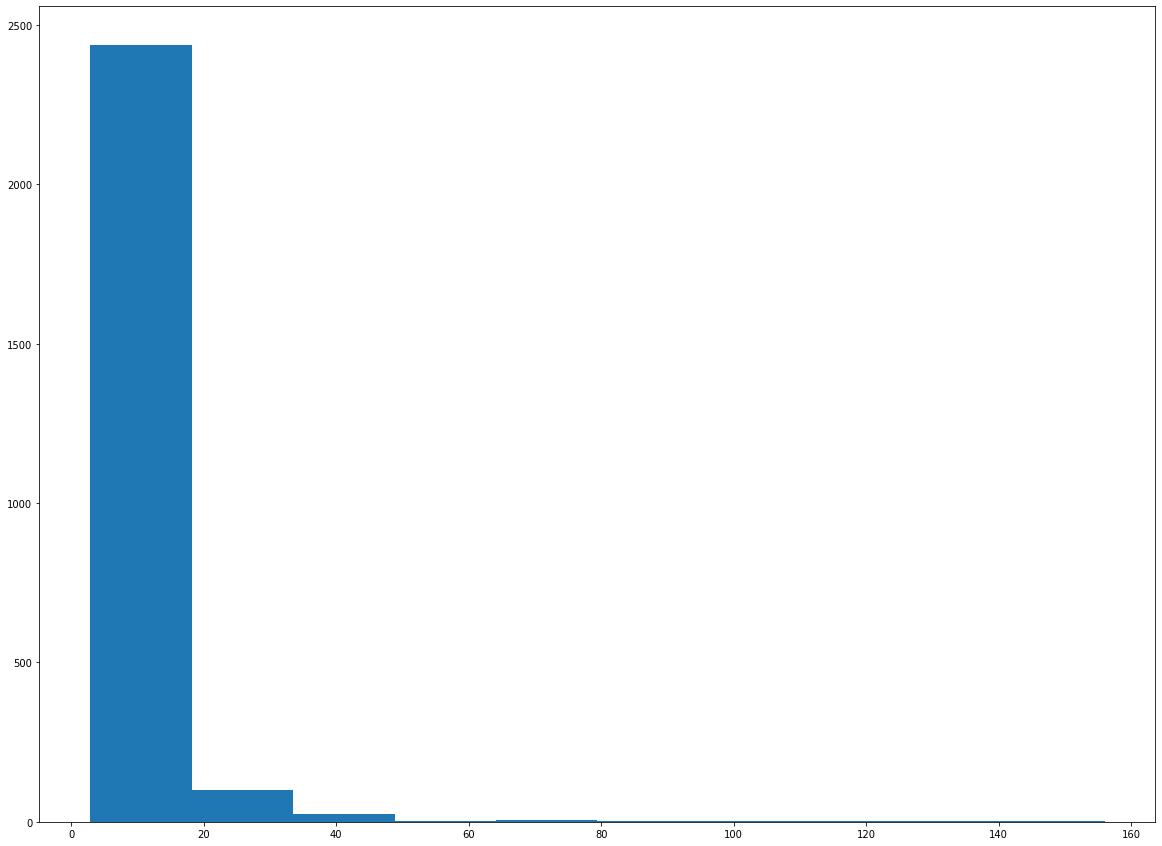

Working for CO2
	Plotting


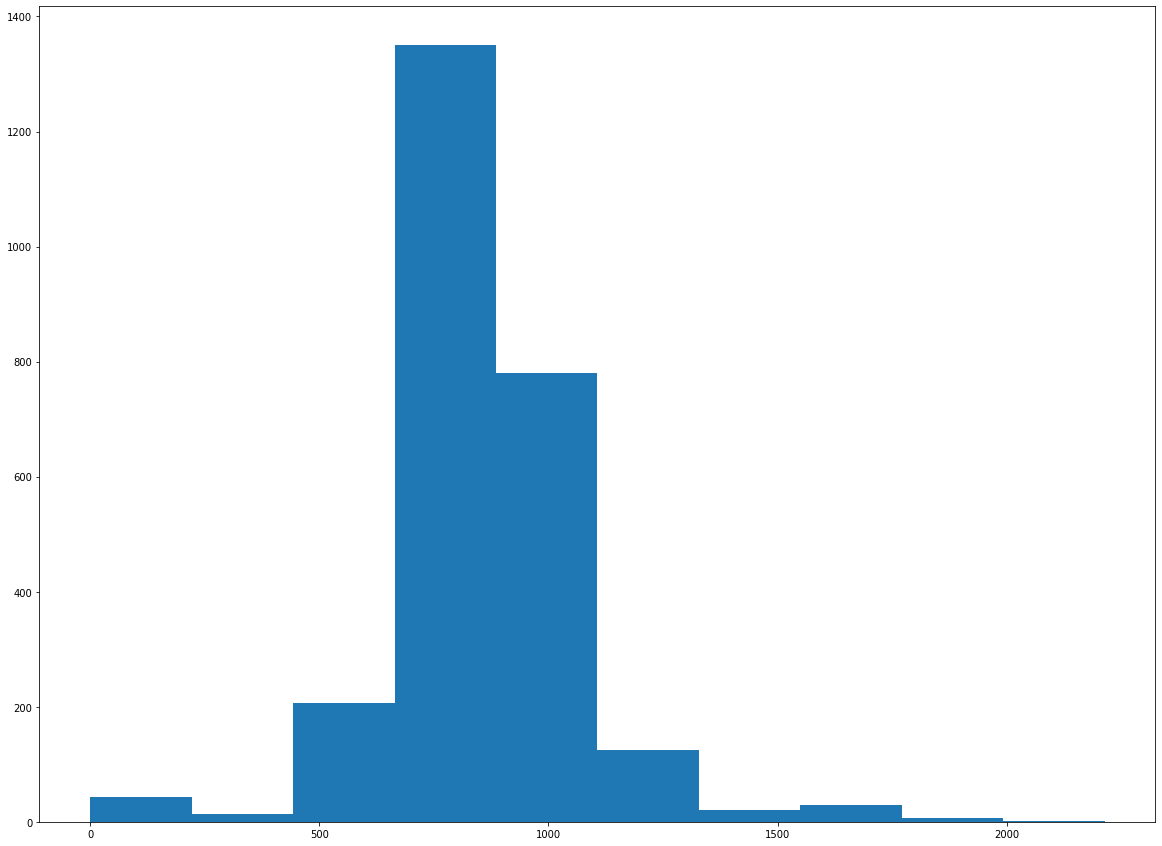

Working for CO
	Plotting


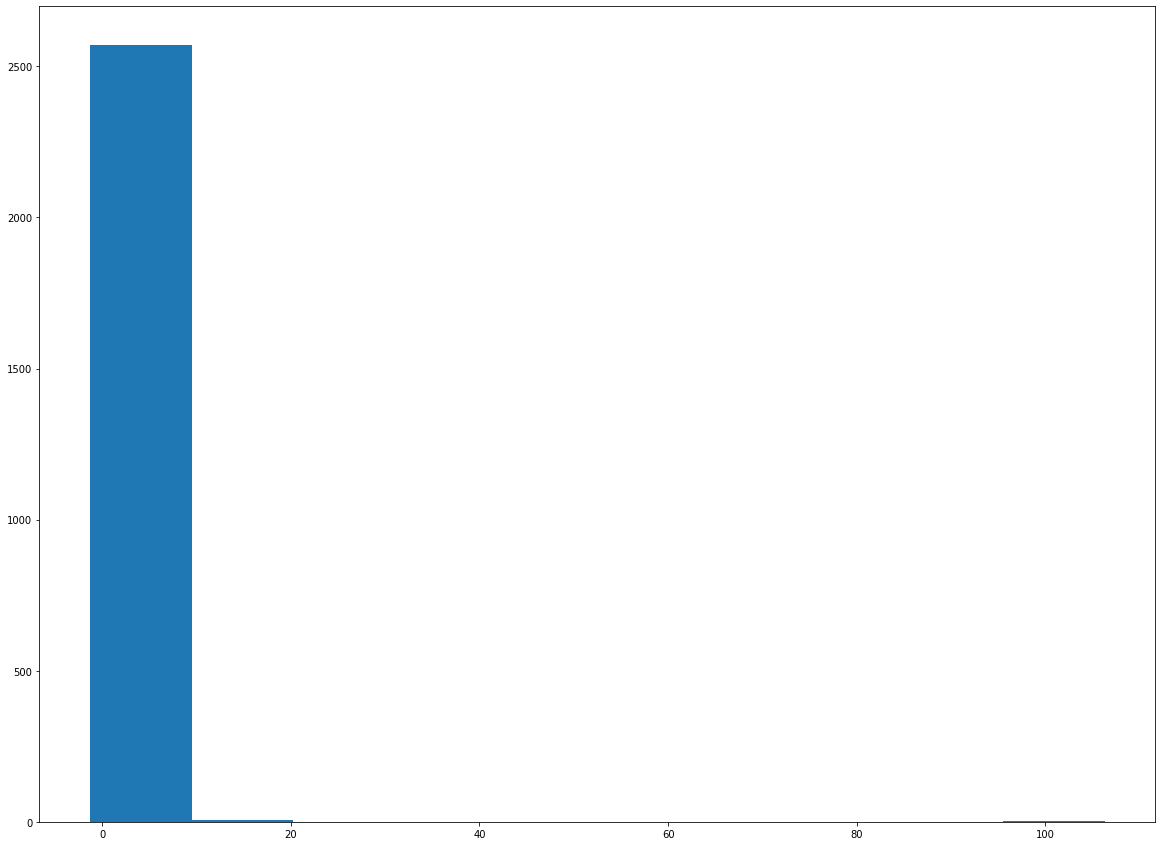

Working for NO2
	Plotting


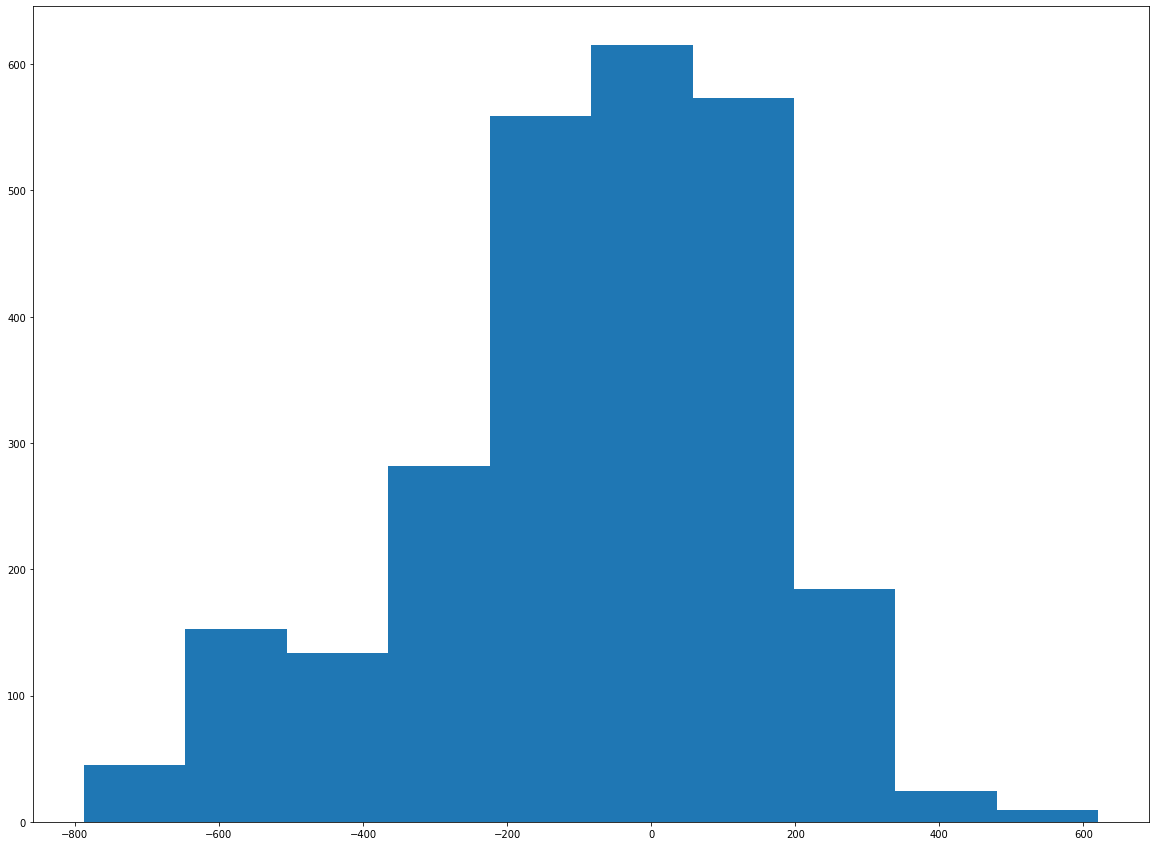

Working for T_NO2
	Plotting


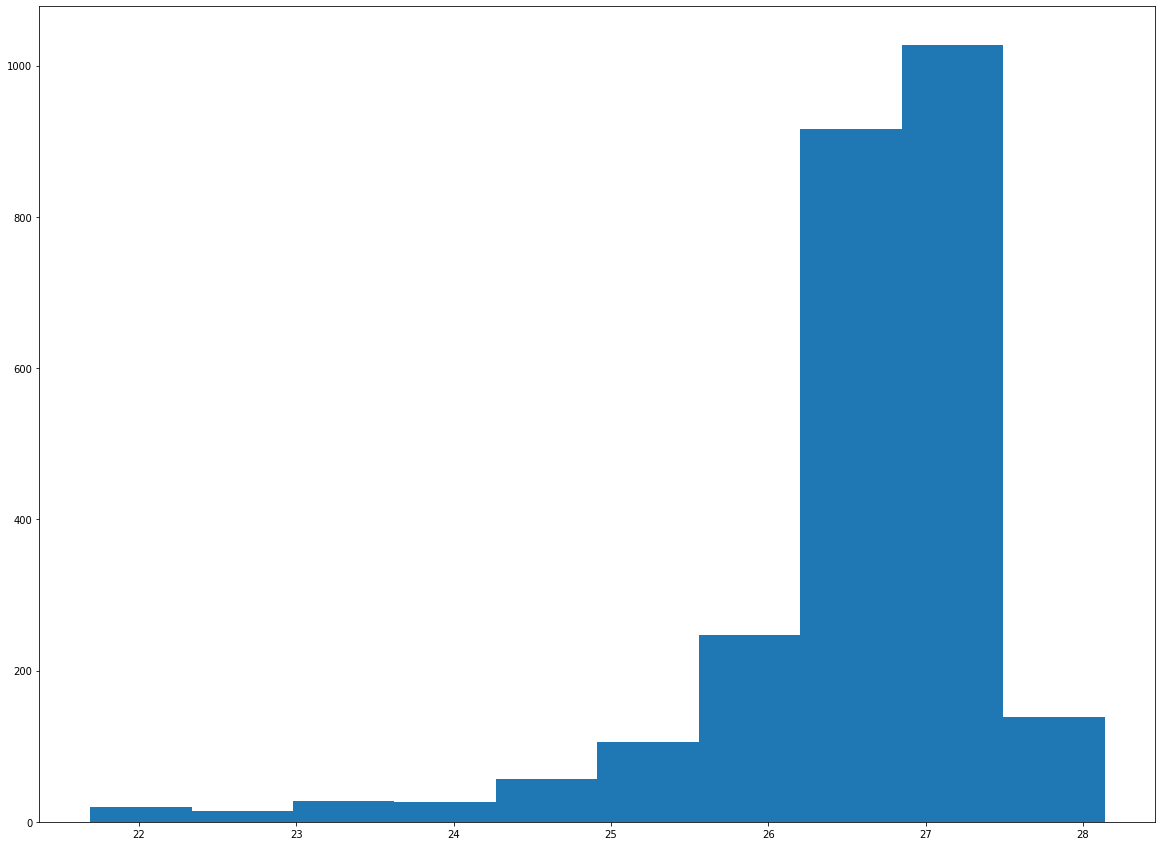

In [5]:
var_list = ['PM_C_2p5','CO2','CO','NO2','T_NO2']
bins=[[0,12,35,55,150,250,10000],
      [0,600,1000,2500,5000,10000],
      [0,4,9,12,15,30],
      [0,50,100,360,650,1250],
      [15,18,20,26,28,31]]
for variable in var_list:
    print(f'Working for {variable}')
    fig, ax = plt.subplots(figsize=(20,15))
    print(f'\tPlotting')
    if variable == 'NO2':
        beacon_data = beacon_data[beacon_data[variable] < 5000]
        
    beacon_data_hourly = beacon_data.resample('60T').mean()
    ax.hist(beacon_data_hourly[variable])
    
    plt.show()
    plt.close()